In [1]:
import sys
sys.path.append('..')

from utils import *
from model import *
from tqdm import trange

import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

In [2]:
# camera = ThinLenCamera(0.1, focal_length=3.5e-3 ,pixel_size=1.4e-5)
camera = ThinLenCamera(8, focal_length=50e-3, pixel_size=1.2e-5)

In [22]:
data_path = '/mnt/petrelfs/sihaozhe/NYUv2-ori'
split = 'test'
rgb_path = os.path.join(data_path,f'{split}_rgb')
dpt_path = os.path.join(data_path, f'{split}_depth')
fs_path = os.path.join(data_path, f'{split}_fs_even')
device = 0
use_cuda = True

In [23]:
if not os.path.exists(fs_path):
    os.mkdir(fs_path)

In [24]:
render = GaussPSF(15)
render.cuda()

GaussPSF()

In [25]:
imglist = [f for f in os.listdir(dpt_path) if os.path.isfile(os.path.join(dpt_path, f))]
imglist.sort()

In [26]:
# imglist

In [27]:
# fd_list = [2, 3, 4.5, 5, 7]
# fd_list = [1, 1.5, 2.5, 4, 6]
fd_list = [1, 3, 5, 7, 9]
# fd_list = [1]
# fd_list = np.linspace(1, 9, 50)

In [28]:
for idx in trange(len(imglist)):
# for idx in [1]:
    exp_aif = cv2.resize(cv2.imread(os.path.join(rgb_path, imglist[idx])), (640//2, 480//2))/255.
    exp_dpt = Image.open(os.path.join(dpt_path, imglist[idx]))
    exp_dpt = np.asarray(exp_dpt, dtype=np.float32)
    exp_dpt = np.clip(np.asarray(exp_dpt, dtype=np.float32) / 1e4, 0.1, 10)
    exp_dpt = cv2.resize(exp_dpt, (640//2, 480//2))
    
    dpt = torch.from_numpy(exp_dpt).unsqueeze(0)
    aif = torch.from_numpy(exp_aif.transpose(2, 0, 1)).type(torch.float32).contiguous()
    
    for i, fd in enumerate(fd_list):
        defocus = camera.getCoC(dpt, fd).type(torch.float32)
        fs = render(aif.unsqueeze(0).cuda(), defocus.cuda())
        im = fs.cpu().numpy()[0].transpose(1, 2, 0) * 255.
        # im = im + 0.002 * np.random.randn(*im.shape) * 255.
        fn = f'{imglist[idx][:-4]}_{str(i).zfill(4)}.png'
        cv2.imwrite(os.path.join(fs_path, fn), im.astype(np.uint8))

100%|██████████| 654/654 [00:52<00:00, 12.57it/s]


In [11]:
# dpt[0, 120, 120]

In [12]:
# 0.006 * np.random.randn(*im.shape) * 255.

In [13]:
# np.linspace(1, 9, 100)[27]

In [14]:
# plt.imshow(exp_aif)

In [30]:
noise = 0.001 * np.random.randn(*im.shape) * 255.

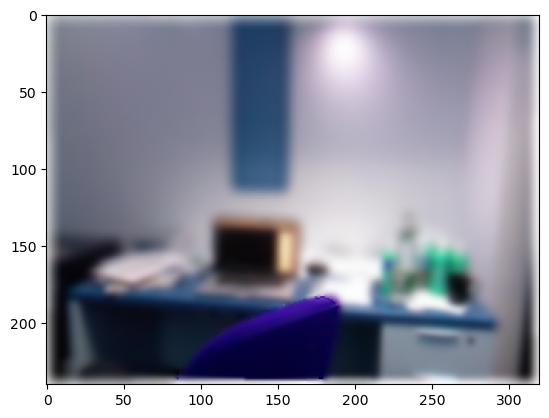

In [31]:
plt.imshow((noise + im).astype(np.uint8))

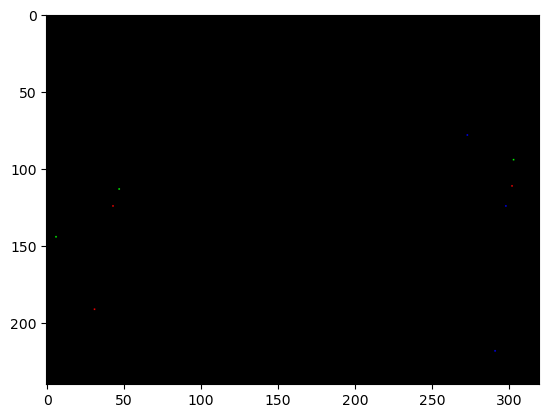

In [32]:
plt.imshow((noise).astype(np.uint8))

### Example

In [13]:
idx = 0
exp_aif = cv2.resize(cv2.imread(os.path.join(rgb_path, imglist[idx])), (640//2, 480//2))/255.
# exp_dpt = cv2.imread(os.path.join(dpt_path, imglist[idx]))[:, :, 0] / 1000.
exp_dpt = Image.open(os.path.join(dpt_path, imglist[idx]))
exp_dpt = np.clip(np.asarray(exp_dpt, dtype=np.float32)/1e4, 0.1, 10)
exp_dpt = np.expand_dims(exp_dpt, axis=2)
# exp_dpt = exp_dpt / exp_dpt.max() 
# exp_dpt = exp_dpt * 9.9 + 0.1
exp_dpt = cv2.resize(exp_dpt, (640//2, 480//2)) 

In [14]:
dpt = torch.from_numpy(exp_dpt).unsqueeze(0)
aif = torch.from_numpy(exp_aif.transpose(2, 0, 1)).type(torch.float32).contiguous()

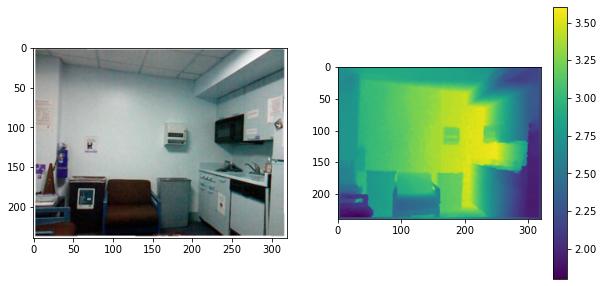

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(exp_aif)
plt.subplot(1, 2, 2)
plt.imshow(exp_dpt)
plt.colorbar()

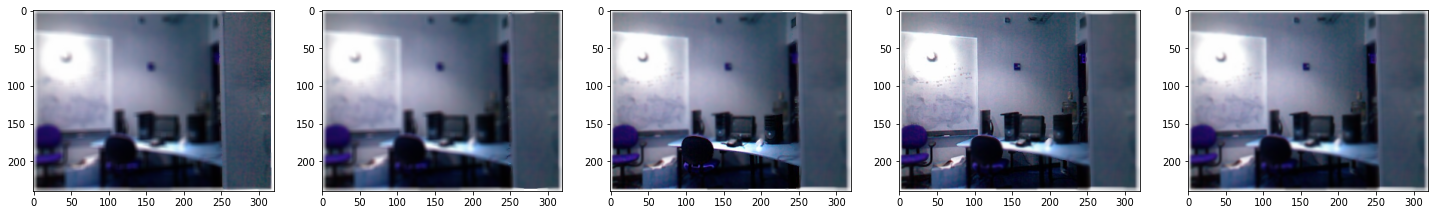

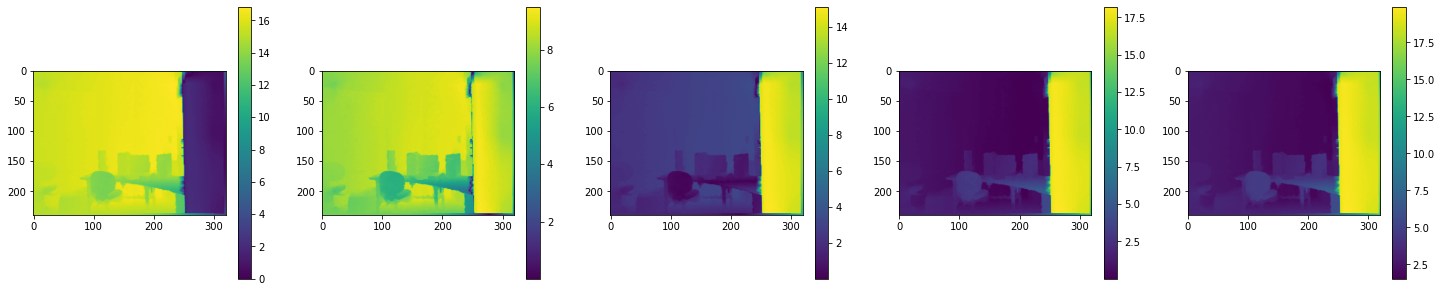

In [29]:
fd_list = [1, 1.5, 2.5, 4, 6]
plt.figure(figsize=(25, 5))
recon_img = []
for i, fd in enumerate(fd_list):
    defocus = camera.getCoC(dpt, fd).type(torch.float32)
    fs = render(aif.unsqueeze(0).cuda(), defocus.cuda())
    recon_img.append(fs)
    plt.subplot(1, 5, i+1)
    plt.imshow(fs.cpu().numpy()[0].transpose(1, 2, 0))
    
plt.figure(figsize=(25, 5))
for i, fd in enumerate(fd_list):
    defocus = camera.getCoC(dpt, fd).type(torch.float32)
    exp_defocus = defocus[0].detach().cpu().numpy()
    plt.subplot(1, 5, i+1)
    plt.imshow(exp_defocus)
    plt.colorbar()

In [30]:
recon_loss = BlurMetric('recon')
sharp_loss = BlurMetric('sharp')
ssim_loss = BlurMetric('ssim')
l1_loss = BlurMetric('l1')
mse_loss = BlurMetric('mse')

In [31]:
metric_recon = np.zeros((6, 6))
metric_sharp = np.zeros((6, 6))
metric_ssim = np.zeros((6, 6))
metric_l1 = np.zeros((6, 6))
metric_mse = np.zeros((6, 6))

In [32]:
for i in range(6):
    for j in range(6):
        if i != 5:
            inp = recon_img[i]
        else:
            inp = aif.unsqueeze(0).cuda()
        if j != 5:
            tar = recon_img[j]
        else:
            tar = aif.unsqueeze(0).cuda()
        metric_recon[i, j] = recon_loss(inp, tar).item()
        metric_sharp[i, j] = sharp_loss(inp, tar).item()
        metric_ssim[i, j] = ssim_loss(inp, tar).item()        
        metric_l1[i, j] = l1_loss(inp, tar).item()
        metric_mse[i, j] = l1_loss(inp, tar).item() 

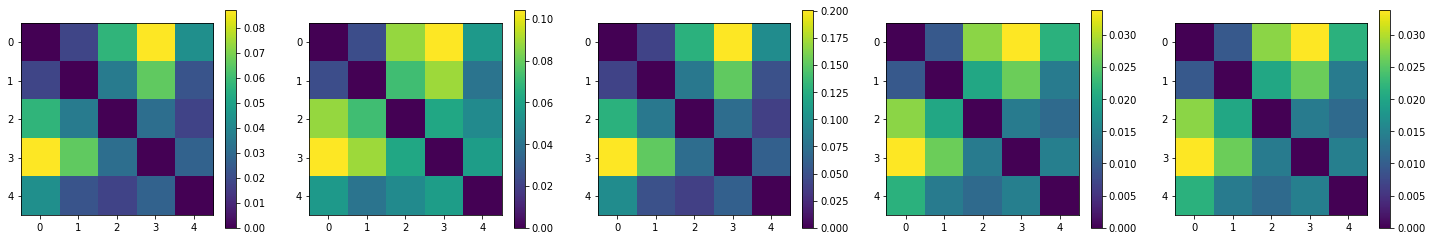

In [33]:
plt.figure(figsize=(25, 4))
for i, n in enumerate([metric_recon, metric_sharp, 1-metric_ssim, metric_l1, metric_mse]):
    plt.subplot(1, 5, i+1)
    plt.imshow(n[:5, :5])
    plt.colorbar()

## Dataset

In [ ]:
dataset_config = {
    'root_dir': data_path,
    'shuffle': False,
    'img_num': 5, 
    'visible_img': 5,
    'focus_dist': [1, 1.5, 2.5, 4, 6],
    'recon_all': True,
    'RGBFD':True,
    'AIF': True,
    'DPT': True,
    'near':0.1,
    'far':10.,
    'scale':2
}
BS = 4

In [ ]:
train_dl, test_dl, _ = load_data(dataset_config, 'NYU', BS)

5 out of 100 images per sample are visible for input
Total number of training sample: 795
Total number of validation sample: 131
Total number of testing sample: 654


In [50]:
dl = iter(test_dl)

In [51]:
exp = next(dl)

In [52]:
dpt = exp['dpt']

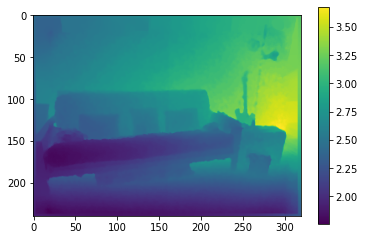

In [53]:
plt.imshow(dpt[0, 0].numpy())
plt.colorbar()

In [54]:
dpt.shape

torch.Size([4, 1, 240, 320])